In [2]:
import sys
sys.path.append('../scripts')
sys.path.append('../processing')
sys.path.append('../datasets')
from fnEDA import *
from load_data import *

def get_data(specific_videos=None):
    directory = read_config("directory")
    video_ids = get_all_video_ids(directory['originalframes'])
    if specific_videos is not None:
        video_ids = [vid for vid in video_ids if vid in specific_videos]
    video_files = []
    key_video_files = []
    embedding_values_list = []
    key_embedding_values_list = []
    for vid in video_ids:
        video_files.extend(load_video_files(vid, directory))
        key_video_files.extend(load_key_video_files(vid, directory))
        embedding_values_list.append(load_embedding_values(load_embedding_files(vid, directory)))
        try:
            key_embedding_values_list.append(load_embedding_values(load_keyframe_embedding_files(vid, directory)))
        except FileNotFoundError:
            print(f"Keyframe embeddings not found for video ID {vid}")
            continue
    embedding_values = normalize(np.concatenate(embedding_values_list, axis=0), axis=1)
    key_embedding_values = normalize(np.concatenate(key_embedding_values_list, axis=0), axis=1)
    return video_files, key_video_files, embedding_values, key_embedding_values


video_files, key_video_files, embedding_values, key_embedding_values = get_data(specific_videos=[1])

# Get video duration
total_duration = get_video_duration(video_files)
# Set start and end indices
start_idx, end_idx = 0, 2000
# Get segmented original frames and embeddings
frame_embedding_pairs, segmented_embeddings = get_segmented_frames_and_embeddings(video_files, embedding_values, total_duration, start_idx, end_idx)
# Get segmented keyframes and embeddings
key_frame_embedding_pairs, key_segmented_embeddings = get_segmented_frames_and_embeddings(key_video_files, key_embedding_values, total_duration, 0, len(key_embedding_values))
print(f"Total frame-embedding pairs: {len(frame_embedding_pairs)}")
print(f"Total key frame-embedding pairs: {len(key_frame_embedding_pairs)}")

Duration in seconds: 332.64 seconds
Average Duration per frame: 0.04 seconds
Average Duration per embedding: 0.1664 seconds
____________________________________________________________________
Duration in seconds: 332.64 seconds
Average Duration per frame: 4.2106 seconds
Average Duration per embedding: 4.2646 seconds
____________________________________________________________________
Total frame-embedding pairs: 1999
Total key frame-embedding pairs: 78


### Review of Process

1. **Download YouTube Video and Extract Keyframes Using video2dataset**
    - `video2dataset` employs `yt-dl` for video downloading and `ffmpeg` for keyframe extraction.
    - This step yields: original videos, keyframes, and the YouTube metadata JSON.

2. **Convert Original Frames and Keyframes to Numpy Array**
    - The original frames and keyframes are processed via `clip-video-encode` to generate their embedding vectors.
    - These vectors are created using a pretrained `laion2b_s34b_b79k ViT-B-32` model.
    - The embeddings act as a compact representation of the frames and keyframes, encapsulating essential visual features.

3. **Analysis, Visualization, and Fine-tuning**
    - A sliding window method and k-NN are utilized to identify segments where the successor value either crosses a specific threshold or shows a unique pattern.
    - After determining optimal values, the script is configured and run to produce image and video keyframes.
    - The primary output consists of 2-15 second clips, each containing 2-4 keyframes that are most representative of the clip's content.

New segment detected at frame 2
New segment detected at frame 7
New segment detected at frame 9
New segment detected at frame 14
New segment detected at frame 21
New segment detected at frame 24
New segment detected at frame 27
New segment detected at frame 28
New segment detected at frame 29
New segment detected at frame 30
New segment detected at frame 32
New segment detected at frame 37
New segment detected at frame 38
New segment detected at frame 39
New segment detected at frame 41
New segment detected at frame 43
New segment detected at frame 44
New segment detected at frame 47
New segment detected at frame 49
New segment detected at frame 51
New segment detected at frame 52
New segment detected at frame 54
New segment detected at frame 55
New segment detected at frame 56
New segment detected at frame 57
New segment detected at frame 58
New segment detected at frame 60
New segment detected at frame 61
New segment detected at frame 62
New segment detected at frame 63
New segment d

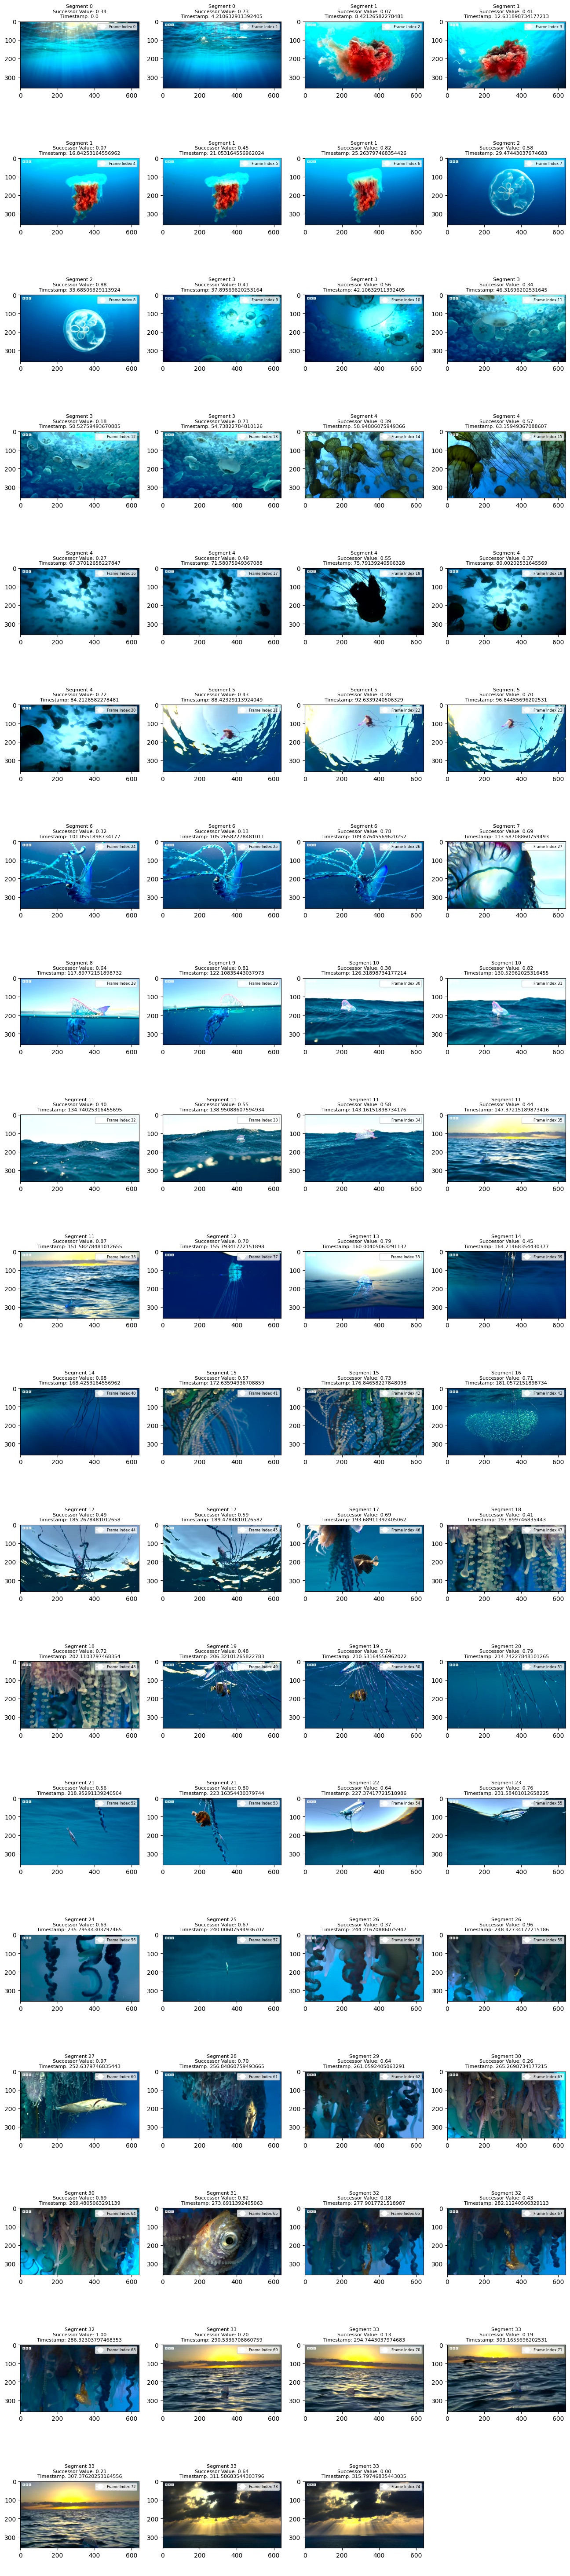

In [3]:
from successor_segmentation import SegmentSuccessorAnalyzer, run_analysis
from fold_seams import main

# To analyze just video 1
run_analysis(SegmentSuccessorAnalyzer, specific_videos=[1])
main(specific_videos=[1])

### 3. Evaluate Embedding Statistics: 
``The description of each measurement is below along with the intended purpose of each. The goal is to identify which measurements are most useful for identifying changes in video content.``
- **Mean All Distances**:  
  This is the average of all pairwise distances between embeddings within a given time window. A higher value is asssumed to indicate a change in visual content, while a lower value could suggest uniformity.

- **Mean Successor Distances**:  
  This is the average of the distances between consecutive embeddings. It can be useful for identifying abrupt changes or transitions in the video content. A higher value indicates a scene change or a significant event.

- **New Segments Count**:  
  This represents the number of new segments identified within the time window. A segment is a contiguous set of frames that are similar to each other based on some criteria (e.g., embedding distance). A higher count indicates frequent changes in the video content.

- **Average Window Length**:  
  This is the average length (in seconds) of the new segments within the time window. A longer average length is assumed longer, more stable scenes, while a shorter length might suggest rapid changes or cuts.

- **Segment Density**:  
  This is the ratio of `New Segments Count` to `Average Window Length`. It provides a measure of how densely new segments are packed within each window. A higher density could indicate more frequent, shorter segments, possibly suggesting a more dynamic or rapidly changing video.

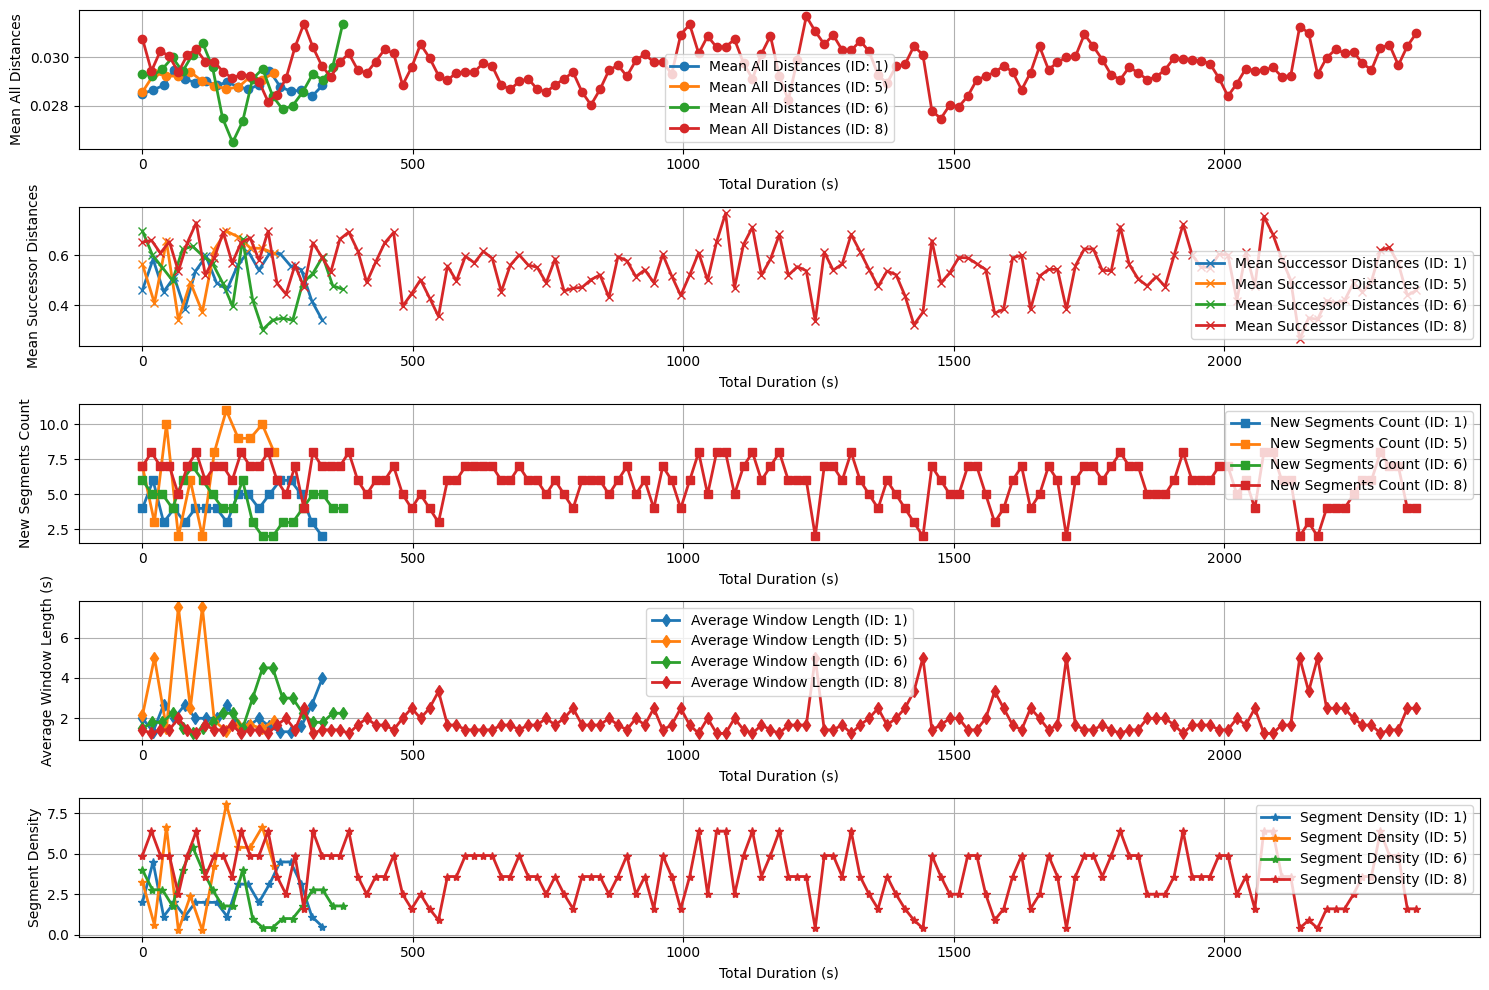

In [8]:
evaluate_embedding_statistics(ids=None) 